In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.3.0


In [2]:
## Loading data and establishing hyperparameters (these are up for debate and can be changed), trying with different csv-files containing different data
#df = pd.read_csv('neural.csv')
df = pd.read_csv('neural_label.csv')
df = df.set_index('DATE')
#df = df.drop(columns={'Open', 'Adj Close'})

#virker som mindre batch size gir bedre resultat for prediksjonen min!
batch_size = 8
seq_len = 32

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256


In [3]:
df.tail()

Close    Volume  4TC_C+1CAL_x  4TC_C+1Q_x  4TC_C+2CAL_x  \
DATE                                                                     
2019-09-19  0.041637  0.395317      0.460690    0.906354      0.319495   
2019-09-20  0.041473  0.398268      0.461195    0.910196      0.319382   
2019-09-23  0.041342  0.394370      0.461961    0.914537      0.319429   
2019-09-24  0.041202  0.394832      0.462530    0.917762      0.319289   
2019-09-25  0.041041  0.386994      0.462616    0.918973      0.318874   

            4TC_C+2Q_x  4TC_CCURQ_x  C4+1CAL_x  C4+1MON_x  C4+2CAL_x  ...  \
DATE                                                                  ...   
2019-09-19    0.380618     0.972406   0.922491   0.684334   0.803810  ...   
2019-09-20    0.382388     0.980007   0.922937   0.688043   0.804494  ...   
2019-09-23    0.384463     0.987219   0.923443   0.691706   0.805182  ...   
2019-09-24    0.386221     0.993965   0.923890   0.695224   0.805876  ...   
2019-09-25    0.387493     1.000000   0.924221   0.698126   0.806581  ...   

            P2ACURMON  P3A+1MON  P3A+2MON  P3A+3MON  P3ACURMON      BDRY  \
DATE                                                                       
2019-09-19   0.988567  0.940259  0.774613  0.709469   0.951735  0.988386   
2019-09-20   0.992277  0.944853  0.777630  0.711542   0.956057  0.992409   
2019-09-23   0.995638  0.949339  0.780570  0.713642   0.960168  0.995727   
2019-09-24   0.998499  0.953608  0.783305  0.715636   0.963785  0.998580   
2019-09-25   1.000000  0.956797  0.785402  0.717018   0.966134  1.000000   

            BRENT_FUTURES   CNY_USD    S&P500   EUR_USD  
DATE                                                     
2019-09-19       0.352132  0.017222  1.000000  0.161413  
2019-09-20       0.351446  0.013356  0.999987  0.159964  
2019-09-23       0.351006  0.008787  0.999883  0.158341  
2019-09-24       0.350096  0.004569  0.999279  0.156780  
2019-09-25       0.349068  0.000000  0.998902  0.154821  

[5 rows x 50 columns]

In [4]:
## normalizing data except the label column wich we like to keep as is
#for column in df:
    #min_volume = df[column].min(axis=0)
    #max_volume = df[column].max(axis=0)
    # Min-max normalize volume columns (0-1 range)
    #df[column] = (df[column] - min_volume) / (max_volume - min_volume)

## splitting in training and test data
times = sorted(df.index.values)
#last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
#last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
last_40pct = sorted(df.index.values)[-int(0.4*len(times))] # Last 40% of series


df_train = df[(df.index < last_40pct)]  # Training data are 80% of total data, concating traning set in cell above
#df_train = pd.concat([df_train0, boot], ignore_index=True)
df_val = df[(df.index >= last_40pct) & (df.index < last_20pct)]
df_test = df[(df.index >= last_20pct)]

# Remove date column
#df_train.drop(columns=['DATE'], inplace=True)
#df_val.drop(columns=['DATE'], inplace=True)
#df_test.drop(columns=['DATE'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (1032, 50)
Validation data shape: (344, 50)
Test data shape: (343, 50)


Close    Volume  4TC_C+1CAL_x  4TC_C+1Q_x  4TC_C+2CAL_x  \
DATE                                                                     
2012-09-14  0.536755  0.048724      0.227859    0.324884      0.439420   
2012-09-17  0.534672  0.048745      0.224247    0.320690      0.435686   
2012-09-18  0.531429  0.049171      0.221260    0.317293      0.432342   
2012-09-19  0.528468  0.050266      0.218344    0.314032      0.429099   
2012-09-20  0.525939  0.050875      0.215929    0.311577      0.426417   

            4TC_C+2Q_x  4TC_CCURQ_x  C4+1CAL_x  C4+1MON_x  C4+2CAL_x  ...  \
DATE                                                                  ...   
2012-09-14    0.154618     0.168906   0.819086   0.465145   0.867729  ...   
2012-09-17    0.152996     0.164732   0.817400   0.463601   0.866600  ...   
2012-09-18    0.151623     0.161017   0.815839   0.461995   0.865444  ...   
2012-09-19    0.150301     0.157524   0.814683   0.461273   0.864302  ...   
2012-09-20    0.149142     0.154833   0.813634   0.461190   0.863357  ...   

            P2ACURMON  P3A+1MON  P3A+2MON  P3A+3MON  P3ACURMON      BDRY  \
DATE                                                                       
2012-09-14   0.471012  0.388355  0.369407  0.359081   0.344500  0.291299   
2012-09-17   0.465149  0.382531  0.364536  0.352025   0.337736  0.285901   
2012-09-18   0.459052  0.378073  0.360264  0.345754   0.330912  0.280674   
2012-09-19   0.452851  0.374167  0.356506  0.340149   0.324429  0.275674   
2012-09-20   0.446736  0.370533  0.352977  0.334875   0.318510  0.271071   

            BRENT_FUTURES   CNY_USD    S&P500   EUR_USD  
DATE                                                     
2012-09-14       0.952051  0.660487  0.000000  0.563021  
2012-09-17       0.955342  0.661365  0.001199  0.567523  
2012-09-18       0.958821  0.662420  0.002538  0.572249  
2012-09-19       0.960799  0.663738  0.003929  0.576783  
2012-09-20       0.963831  0.665056  0.005449  0.581241  

[5 rows x 50 columns]

In [5]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 64(or other set seq ln) df-rows
  y_train.append(train_data[:, 0][i]) #Value of xth column/x-1. index (Adj.Close) of df-row 64+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1000, 32, 50) (1000,)
(312, 32, 50) (312,)


In [6]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    #mulig denne må endres da 4 spiller på antall features!
    x = tf.math.reduce_mean(x[:,:,:46], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [7]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 50)]     0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 32, 2)        128         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 52)       0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 32, 52)       675384      concatenate[0][0]     

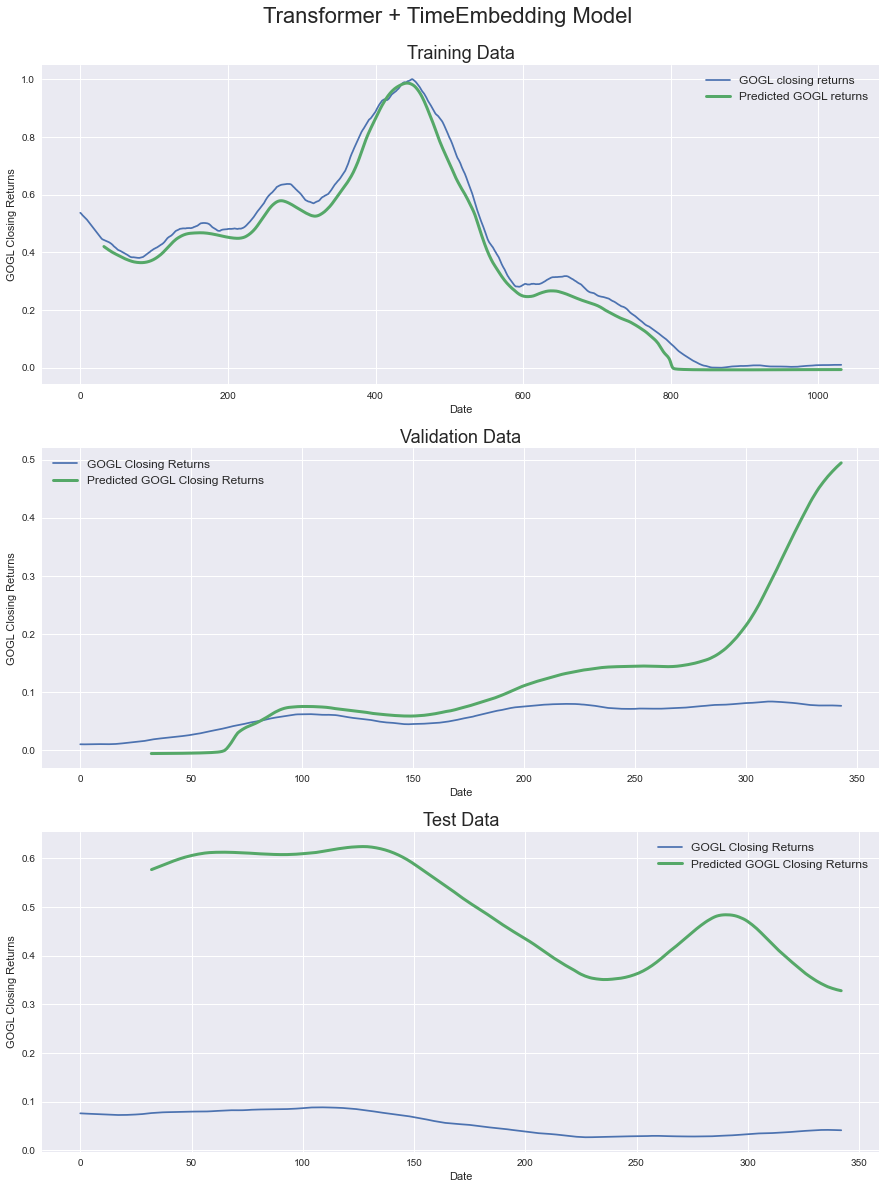

In [8]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape = (seq_len, 50))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=10, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model(r'C:\Users\larsm\OneDrive\NHH\Master\Høst20\Masteroppgave/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 0], label='GOGL closing returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted GOGL returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('GOGL Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 0], label='GOGL Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted GOGL Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('GOGL Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 0], label='GOGL Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted GOGL Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('GOGL Closing Returns')
ax31.legend(loc="best", fontsize=12)

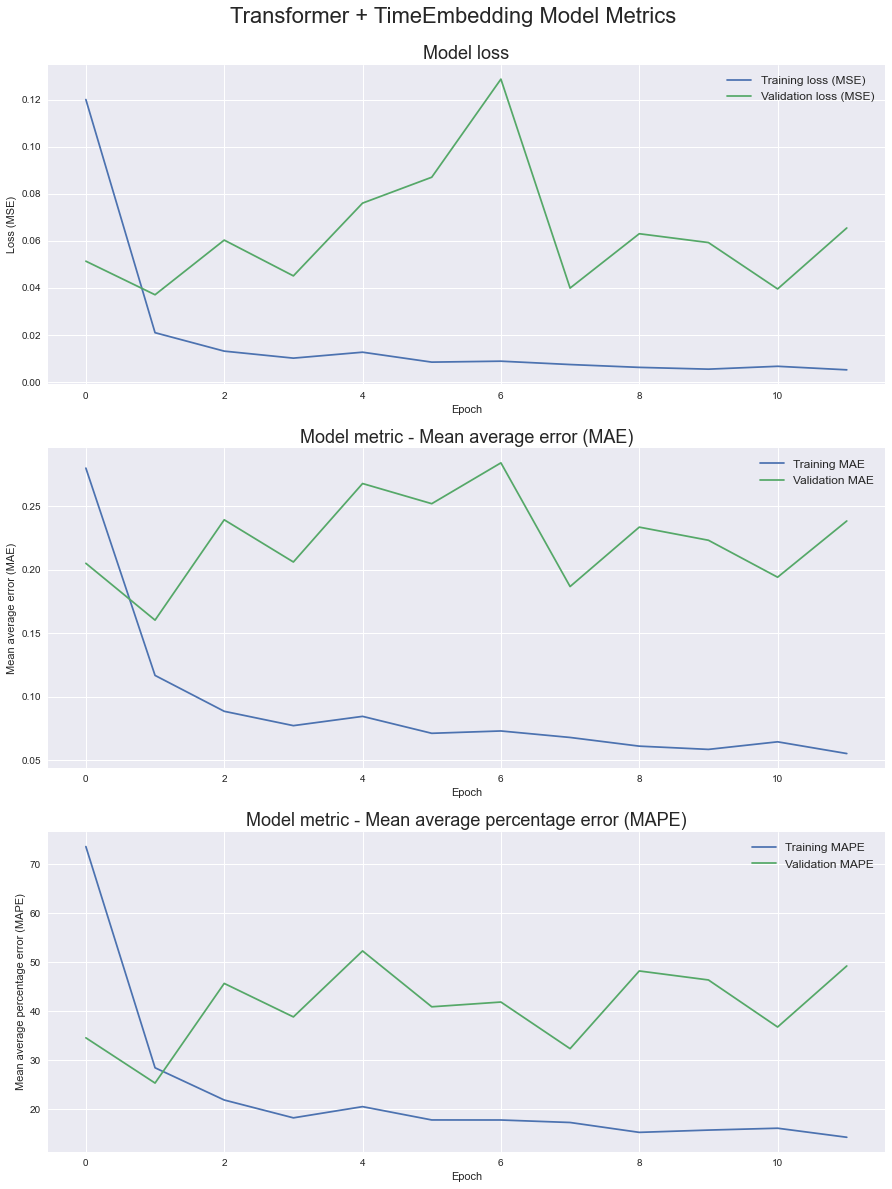

In [8]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

Calculating profit


In [42]:
#type(test_pred)
test_pred.tolist()
gogl = pd.read_csv('GOGL.csv')

In [49]:
df.tail()

Close    Volume  4TC_C+1CAL_x  4TC_C+1Q_x  4TC_C+2CAL_x  \
DATE                                                                     
2019-09-19  0.041637  0.395317      0.460690    0.906354      0.319495   
2019-09-20  0.041473  0.398268      0.461195    0.910196      0.319382   
2019-09-23  0.041342  0.394370      0.461961    0.914537      0.319429   
2019-09-24  0.041202  0.394832      0.462530    0.917762      0.319289   
2019-09-25  0.041041  0.386994      0.462616    0.918973      0.318874   

            4TC_C+2Q_x  4TC_CCURQ_x  C4+1CAL_x  C4+1MON_x  C4+2CAL_x  ...  \
DATE                                                                  ...   
2019-09-19    0.380618     0.972406   0.922491   0.684334   0.803810  ...   
2019-09-20    0.382388     0.980007   0.922937   0.688043   0.804494  ...   
2019-09-23    0.384463     0.987219   0.923443   0.691706   0.805182  ...   
2019-09-24    0.386221     0.993965   0.923890   0.695224   0.805876  ...   
2019-09-25    0.387493     1.000000   0.924221   0.698126   0.806581  ...   

            P2ACURMON  P3A+1MON  P3A+2MON  P3A+3MON  P3ACURMON      BDRY  \
DATE                                                                       
2019-09-19   0.988567  0.940259  0.774613  0.709469   0.951735  0.988386   
2019-09-20   0.992277  0.944853  0.777630  0.711542   0.956057  0.992409   
2019-09-23   0.995638  0.949339  0.780570  0.713642   0.960168  0.995727   
2019-09-24   0.998499  0.953608  0.783305  0.715636   0.963785  0.998580   
2019-09-25   1.000000  0.956797  0.785402  0.717018   0.966134  1.000000   

            BRENT_FUTURES   CNY_USD    S&P500   EUR_USD  
DATE                                                     
2019-09-19       0.352132  0.017222  1.000000  0.161413  
2019-09-20       0.351446  0.013356  0.999987  0.159964  
2019-09-23       0.351006  0.008787  0.999883  0.158341  
2019-09-24       0.350096  0.004569  0.999279  0.156780  
2019-09-25       0.349068  0.000000  0.998902  0.154821  

[5 rows x 50 columns]

In [50]:
len(test_pred)


139

In [66]:
## Matcher prediksjonsdato med kurs, Beholder de x siste radene som vi har prediksjon på.
df1 = gogl.iloc[4683:4822]
df1.head()

Date  Open  High   Low  Close  Adj Close  Volume
4683  2019-03-12  4.83  4.91  4.80   4.89   4.607858  140100
4684  2019-03-13  4.98  5.02  4.90   4.92   4.636126  131500
4685  2019-03-14  5.10  5.14  5.06   5.12   4.824587  209400
4686  2019-03-15  5.19  5.21  5.03   5.06   4.768049  480300
4687  2019-03-18  4.95  4.95  4.84   4.85   4.570165  268800

In [67]:
df1['pred'] = test_pred

In [69]:
df1 = df1.dropna()
df1.tail()

Date  Open  High   Low  Close  Adj Close  Volume      pred
4817  2019-09-20  6.03  6.07  5.90   5.92   5.702165  321000  0.082967
4818  2019-09-23  5.98  6.12  5.96   6.06   5.837014  143700  0.082755
4819  2019-09-24  6.25  6.28  5.99   6.03   5.808118  198000  0.082547
4820  2019-09-25  5.85  5.92  5.83   5.91   5.692533  170800  0.082351
4821  2019-09-26  5.82  5.87  5.80   5.82   5.605845  181500  0.082165

In [70]:
df1.to_csv(r'C:\Users\larsm\OneDrive\NHH\Master\Høst20\Masteroppgave\profit.csv', index=False)

In [ ]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)